# Aiida

In [1]:
import subprocess

In [2]:
try: 
    subprocess.check_output(["verdi", "profile", "setup", "core.sqlite_dos", "-n", "--profile", "test", "--email", "no@email.com"])
except: 
    pass

/srv/conda/envs/notebook/lib/python3.11/site-packages/aiida/manage/configuration/settings.py:59: UserWarning: Creating AiiDA configuration folder `/home/jovyan/.aiida`.
  warnings.warn(f'Creating AiiDA configuration folder `{path}`.')


In [3]:
from pathlib import Path
from ase.build import bulk

from aiida import orm, engine, load_profile
from aiida.common.exceptions import NotExistent

load_profile()

Profile<uuid='970c10a80dad4217a0f75cca3dd833b2' name='test'>

In [4]:
try:
    localhost = orm.load_computer('localhost')
except NotExistent:
    localhost = orm.Computer(
        label='localhost',
        hostname='localhost',
        transport_type='core.local',
        scheduler_type='core.direct',
        workdir=Path('workdir').absolute().as_posix()
    ).store()
    localhost.configure()

try:
    pw_code = orm.load_code('pw@localhost')
except NotExistent:
    pw_code = orm.InstalledCode(
        label='pw',
        computer=localhost,
        filepath_executable='pw.x',
        default_calc_job_plugin='aiida_qe_basic.pw',
        prepend_text='export OMP_NUM_THREADS=1'
    ).store()

/srv/conda/envs/notebook/lib/python3.11/site-packages/aiida/orm/nodes/data/code/legacy.py:42: AiidaDeprecationWarning: The `Code` class is deprecated. To create an instance, use the `aiida.orm.nodes.data.code.installed.InstalledCode` or `aiida.orm.nodes.data.code.portable.PortableCode` for a "remote" or "local" code, respectively. If you are using this class to compare type, e.g. in `isinstance`, use `aiida.orm.nodes.data.code.abstract.AbstractCode`. (this will be removed in v3)
  warn_deprecation(


In [5]:
from aiida_qe_basic.pw import PwCalculation

builder = PwCalculation.get_builder()

builder.code = pw_code
builder.structure = orm.StructureData(ase=bulk('Al', a=4.05, cubic=True))
builder.pseudopotentials = orm.Dict({"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"})
builder.parameters = orm.Dict(
    {
        'CONTROL': {
            'calculation': 'scf',
            # 'pseudo_dir': Path('files').absolute().as_posix(),
        },
        'SYSTEM': {
            'occupations': 'smearing',
            'smearing': 'cold',
            'degauss': 0.02
        }
    }
)
builder.metadata.options.resources = {
    'num_machines': 1,
    'num_mpiprocs_per_machine': 1
}

In [6]:
! rabbitmq-server -detached

In [7]:
! sleep 5

In [8]:
results = engine.run(builder)

In [9]:
results

{'structure': <StructureData: uuid: 2139a72b-1693-41e5-b4a2-212ef6852ddf (pk: 8)>,
 'properties': <Dict: uuid: 1900ab56-ffd9-4739-8557-d428af731e8d (pk: 9)>,
 'remote_folder': <RemoteData: uuid: aa74ac59-2511-44c4-ad67-27999a687256 (pk: 6)>,
 'retrieved': <FolderData: uuid: e7ec1c33-f4cd-416b-96d0-defb7c21acd3 (pk: 7)>}

In [10]:
results['properties'].get_dict()

{'energy': -1074.9272223013, 'volume': 66.430124128914}

## Equation of State curve - basic QE

Running an EOS without all the fancy features in the `aiida-quantumespresso` plugin.

In [11]:
from pathlib import Path

from aiida import orm, engine, load_profile

load_profile()

Profile<uuid='970c10a80dad4217a0f75cca3dd833b2' name='test'>

### Importing a structure

In [12]:
from ase.build import bulk

structure = orm.StructureData(ase=bulk('Al', a=4.05, cubic=True))

### Relaxing the geometry

In [13]:
resources = {
    'num_machines': 1,
    'num_mpiprocs_per_machine': 1
}

relax_params = {
    'CONTROL': {
        'calculation': 'vc-relax',
        # 'pseudo_dir': Path('files').absolute().as_posix(),
    },
    'SYSTEM': {
        'occupations': 'smearing',
        'smearing': 'cold',
        'degauss': 0.02
    }
}

In [14]:
from aiida_qe_basic.pw import PwCalculation

builder = PwCalculation.get_builder()

builder.code = orm.load_code('pw@localhost')
builder.structure = orm.StructureData(ase=bulk('Al', a=4.05, cubic=True))
builder.pseudopotentials = orm.Dict({"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"})
builder.parameters = orm.Dict(relax_params)
builder.metadata.options.resources = resources

In [15]:
results = engine.run(builder)
relaxed_structure = results['structure']
relaxed_structure

<StructureData: uuid: 5a9342f9-9b10-4fa7-aa93-f698bcff99ea (pk: 16)>

### Calc function to rescale structures

The `calcfunction` below takes an input structure and rescales it to different volumes.

In [16]:
from aiida_qe_basic.pw import PwCalculation

@engine.calcfunction
def rescale_list(structure: orm.StructureData, factor_list: orm.List):

    scaled_structure_dict = {}

    for index, scaling_factor in enumerate(factor_list.get_list()):

        ase_structure = structure.get_ase()

        new_cell = ase_structure.get_cell() * scaling_factor
        ase_structure.set_cell(new_cell, scale_atoms=True)

        scaled_structure_dict[f'structure_{index}'] = orm.StructureData(ase=ase_structure)

    return scaled_structure_dict

Typically, you'd just run it by calling the function as you would a regular Python function:

In [17]:
rescaled_structures = rescale_list(relaxed_structure, orm.List(list=[0.9, 0.95, 1.0, 1.05, 1.1]))

In [18]:
rescaled_structures

{'structure_0': <StructureData: uuid: 2d23a147-e7c8-41b2-8b73-4e29dd81c5f3 (pk: 20)>,
 'structure_1': <StructureData: uuid: 497a082c-a78e-4719-86c5-48317b85b5a1 (pk: 21)>,
 'structure_2': <StructureData: uuid: f89b8859-723a-4455-9661-ae4dad051635 (pk: 22)>,
 'structure_3': <StructureData: uuid: 0982098b-5590-44f8-8d0b-62741c3d2644 (pk: 23)>,
 'structure_4': <StructureData: uuid: 692a9438-9b0f-45c0-b661-897de3c5b829 (pk: 24)>}

## EOS: Work function version

In [19]:
scf_inputs = {
    'CONTROL': {
        'calculation': 'scf',
        # 'pseudo_dir': Path('files').absolute().as_posix(),
    },
    'SYSTEM': {
        'occupations': 'smearing',
        'smearing': 'cold',
        'degauss': 0.02
    }
}

In [20]:
@engine.workfunction
def run_eos_wf(code: orm.Code, structure: orm.StructureData, scale_factors: orm.List):
    """Run an equation of state of a bulk crystal structure for the given element."""

    properties = {}

    for label, rescaled_structure in rescale_list(structure, scale_factors).items():

        builder = PwCalculation.get_builder()
        builder.code = code
        builder.structure = rescaled_structure
        builder.parameters = orm.Dict(scf_inputs)
        builder.pseudopotentials = orm.Dict({"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"})
        builder.metadata.options.resources = resources

        results = engine.run(builder)
        properties[label] = results['properties']

    return properties

In [21]:
results = run_eos_wf(
    code=orm.load_code('pw@localhost'),
    structure=relaxed_structure,
    scale_factors=[0.9, 0.95, 1.0, 1.05, 1.1]
)

In [22]:
results

{'structure_0': <Dict: uuid: 25b4d82f-b06f-48b3-9d24-2724d8c6306c (pk: 39)>,
 'structure_1': <Dict: uuid: d1ce257f-eb9c-4af3-be3a-ffb6371e045d (pk: 46)>,
 'structure_2': <Dict: uuid: afaa090a-7503-45dc-9cd7-b7eef2d75317 (pk: 53)>,
 'structure_3': <Dict: uuid: bb27de53-405a-448c-8b46-ec40843e6a86 (pk: 60)>,
 'structure_4': <Dict: uuid: e0fcc577-30c3-40c0-a193-548ac2d51b93 (pk: 67)>}

In [23]:
volumes = []
energies = []

for result in results.values():
    volumes.append(result['volume'])
    energies.append(result['energy'])

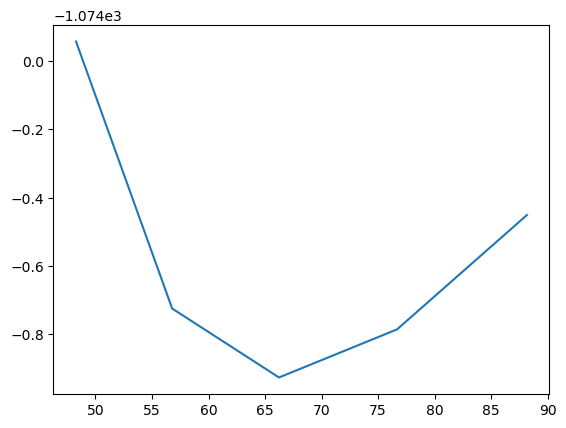

In [24]:
import matplotlib.pyplot as plt

plt.plot(volumes, energies)

## Work chain version

In [25]:
@engine.calcfunction
def create_eos_dictionary(**kwargs) -> orm.Dict:
    eos = {
        label: (result['volume'], result['energy'])
        for label, result in kwargs.items()
    }
    return orm.Dict(eos)

In [26]:
create_eos_dictionary(**results).get_dict()

{'structure_0': [48.283007573324, -1073.9421694118],
 'structure_1': [56.785519366503, -1074.7251942208],
 'structure_2': [66.231834805659, -1074.9273047095],
 'structure_3': [76.671627766898, -1074.7863009779],
 'structure_4': [88.154572126333, -1074.451028786]}

In [27]:
class EquationOfState(engine.WorkChain):
    """WorkChain to compute Equation of State using Quantum ESPRESSO."""

    @classmethod
    def define(cls, spec):
        """Specify inputs and outputs."""
        super().define(spec)
        spec.input("code", valid_type=orm.Code)
        spec.input("structure", valid_type=orm.StructureData)
        spec.input("scale_factors", valid_type=orm.List)

        spec.outline(
            cls.run_eos,
            cls.results,
        )
        spec.output("eos_dict", valid_type=orm.Dict)

    def run_eos(self):

        calcjob_dict = {}

        for label, rescaled_structure in rescale_list(self.inputs.structure, self.inputs.scale_factors).items():

            builder = PwCalculation.get_builder()
            builder.code = self.inputs.code
            builder.structure = rescaled_structure
            builder.parameters = orm.Dict(scf_inputs)
            builder.pseudopotentials = orm.Dict({"Al": "Al.pbe-n-kjpaw_psl.1.0.0.UPF"})
            builder.metadata.options.resources = resources

            calcjob_dict[label] = self.submit(builder)

        self.ctx.labels = list(calcjob_dict.keys())

        return calcjob_dict

    def results(self):

        self.report(self.ctx)

        eos_results = {
            label: self.ctx[label].outputs['properties'] for label in self.ctx.labels
        }
        eos_dict = create_eos_dictionary(**eos_results)
        self.out('eos_dict', eos_dict)


In [28]:
engine.run(EquationOfState, code=orm.load_code('pw@localhost'),
           structure=relaxed_structure,
           scale_factors=orm.List([0.9, 0.95, 1.0, 1.05, 1.1]))

04/04/2024 05:40:39 PM <83> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [71|EquationOfState|results]: AttributeDict({'labels': ['structure_0', 'structure_1', 'structure_2', 'structure_3', 'structure_4'], 'structure_0': <CalcJobNode: uuid: 444fc6e6-f85f-4d91-a8d6-d0d8a5391be2 (pk: 80) (aiida.calculations:qe.pw)>, 'structure_1': <CalcJobNode: uuid: 5ffc349a-078d-4dd8-afdd-9bf857a0a761 (pk: 83) (aiida.calculations:qe.pw)>, 'structure_2': <CalcJobNode: uuid: 0623b121-39ad-4751-833a-3fd5b445578b (pk: 86) (aiida.calculations:qe.pw)>, 'structure_3': <CalcJobNode: uuid: bc77a827-5f32-4804-8844-f71ee458594e (pk: 89) (aiida.calculations:qe.pw)>, 'structure_4': <CalcJobNode: uuid: 19862df7-1e4e-4ddf-ac68-08390ab2207b (pk: 92) (aiida.calculations:qe.pw)>})


{'eos_dict': <Dict: uuid: f0e400dc-33cc-486e-baac-b67c2d2a83c3 (pk: 114)>}

## Using the `builder`

In [29]:
builder = EquationOfState.get_builder()

In [30]:
builder.structure = relaxed_structure

In [31]:
builder

Process class: EquationOfState
Inputs:
metadata: {}
structure: Al


In [32]:
builder.scale_factors = orm.List([0.9, 0.95, 1.0, 1.05, 1.1])
builder.code = orm.load_code('pw@localhost')

In [33]:
results, node = engine.run_get_node(builder)

04/04/2024 05:41:05 PM <83> aiida.orm.nodes.process.workflow.workchain.WorkChainNode: [REPORT] [116|EquationOfState|results]: AttributeDict({'labels': ['structure_0', 'structure_1', 'structure_2', 'structure_3', 'structure_4'], 'structure_0': <CalcJobNode: uuid: 4c5d1fc6-220e-4ded-809a-d6d2e0c33994 (pk: 125) (aiida.calculations:qe.pw)>, 'structure_1': <CalcJobNode: uuid: a37cc25c-3be7-420a-a297-6da6feede4ed (pk: 128) (aiida.calculations:qe.pw)>, 'structure_2': <CalcJobNode: uuid: b354499e-f43a-4aa3-ae0d-383573d8d4ed (pk: 131) (aiida.calculations:qe.pw)>, 'structure_3': <CalcJobNode: uuid: ee507eb7-e4c3-48e5-b75c-4e7095f36908 (pk: 134) (aiida.calculations:qe.pw)>, 'structure_4': <CalcJobNode: uuid: 73b0118b-ad3a-40d6-b6e1-cb9e9befb761 (pk: 137) (aiida.calculations:qe.pw)>})


In [34]:
results['eos_dict'].get_dict()

{'structure_0': [48.283007573324, -1073.9421694118],
 'structure_1': [56.785519366503, -1074.7251942208],
 'structure_2': [66.231834805659, -1074.9273047095],
 'structure_3': [76.671627766898, -1074.7863009779],
 'structure_4': [88.154572126333, -1074.451028786]}

In [35]:
eos = node.outputs.eos_dict.get_dict()

In [36]:
eos

{'structure_0': [48.283007573324, -1073.9421694118],
 'structure_1': [56.785519366503, -1074.7251942208],
 'structure_2': [66.231834805659, -1074.9273047095],
 'structure_3': [76.671627766898, -1074.7863009779],
 'structure_4': [88.154572126333, -1074.451028786]}

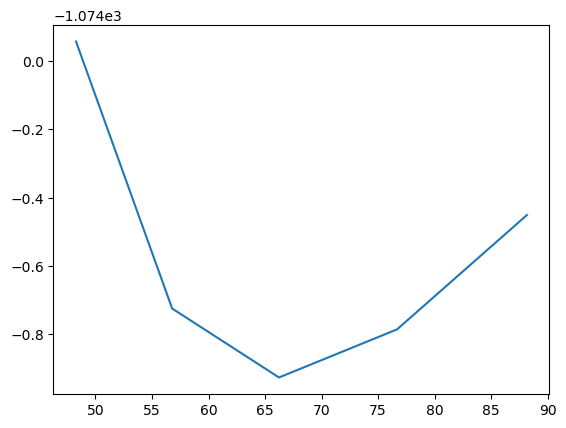

In [37]:
plt.plot(
    [v[0] for v in eos.values()],
    [v[1] for v in eos.values()],
)